# Inspect the single-lineage models run so far (004)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns
from IPython.display import Markdown, display

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import (
    LineageHierNegBinomModel,
    LineageHierNegBinomModelData,
)
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


class PosteriorManager:
    def __init__(self, lineage: str) -> None:
        self.lineage = lineage
        self.posterior_dir = (
            models_dir() / f"hnb-single-lineage-{lineage}-004_PYMC_NUMPYRO"
        )
        self._posterior_summary: pd.DataFrame | None = None
        self._trace: az.InferenceData | None = None
        self._lineage_model: LineageHierNegBinomModel | None = None
        self._data: pd.DataFrame | None = None
        self._valid_data: pd.DataFrame | None = None
        self._model_data_struct: LineageHierNegBinomModelData | None = None
        return None

    @property
    def posterior_summary(self) -> pd.DataFrame:
        if self._posterior_summary is not None:
            return self._posterior_summary
        self._posterior_summary = pd.read_csv(
            self.posterior_dir / "posterior-summary.csv"
        ).assign(var_name=lambda d: [x.split("[")[0] for x in d["parameter"]])
        return self._posterior_summary

    @property
    def trace(self) -> az.InferenceData:
        if self._trace is not None:
            return self._trace
        self._trace = az.from_netcdf(self.posterior_dir / "posterior.netcdf")
        return self._trace

    @property
    def data(self) -> pd.DataFrame:
        if self._data is not None:
            return self._data
        self._data = CrisprScreenDataManager(
            modeling_data_dir()
            / "lineage-modeling-data"
            / f"depmap-modeling-data_{self.lineage}.csv",
            transformations=[_broad_only],
        ).get_data(read_kwargs={"low_memory": False})
        return self._data

    @property
    def lineage_model(self) -> LineageHierNegBinomModel:
        if self._lineage_model is None:
            self._lineage_model = LineageHierNegBinomModel(lineage=self.lineage)
        return self._lineage_model

    @property
    def valid_data(self) -> pd.DataFrame:
        if self._valid_data is not None:
            return self._valid_data
        self._valid_data = self.lineage_model.data_processing_pipeline(self.data.copy())
        return self._valid_data

    @property
    def model_data_struct(self) -> LineageHierNegBinomModelData:
        if self._model_data_struct is not None:
            return self._model_data_struct
        self._model_data_struct = self.lineage_model.make_data_structure(
            self.valid_data
        )
        return self._model_data_struct

In [6]:
LINEAGES = ["prostate", "liver"]  # "colorectal"

posteriors: dict[str, PosteriorManager] = {
    line: PosteriorManager(line) for line in LINEAGES
}

## Analysis

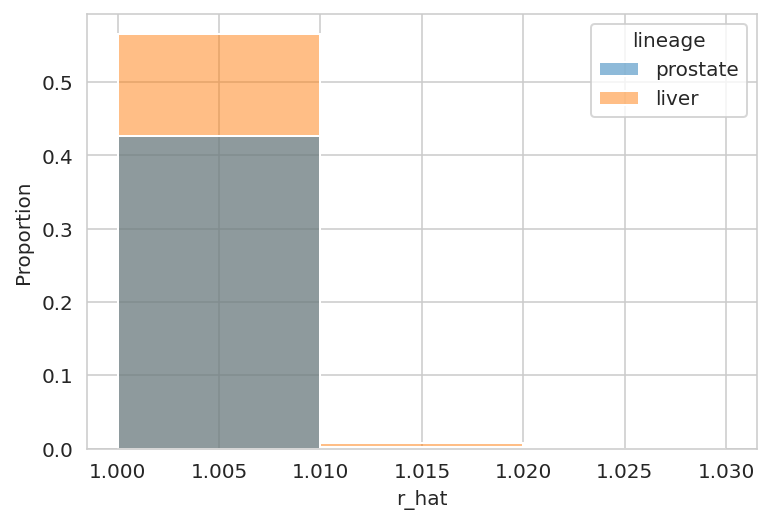

In [7]:
posterior_summaries_df = pd.concat(
    [
        pm.posterior_summary.copy().assign(lineage=pm.lineage)
        for pm in posteriors.values()
    ]
).reset_index(drop=True)

sns.histplot(
    data=posterior_summaries_df,
    x="r_hat",
    hue="lineage",
    binwidth=0.01,
    stat="proportion",
);

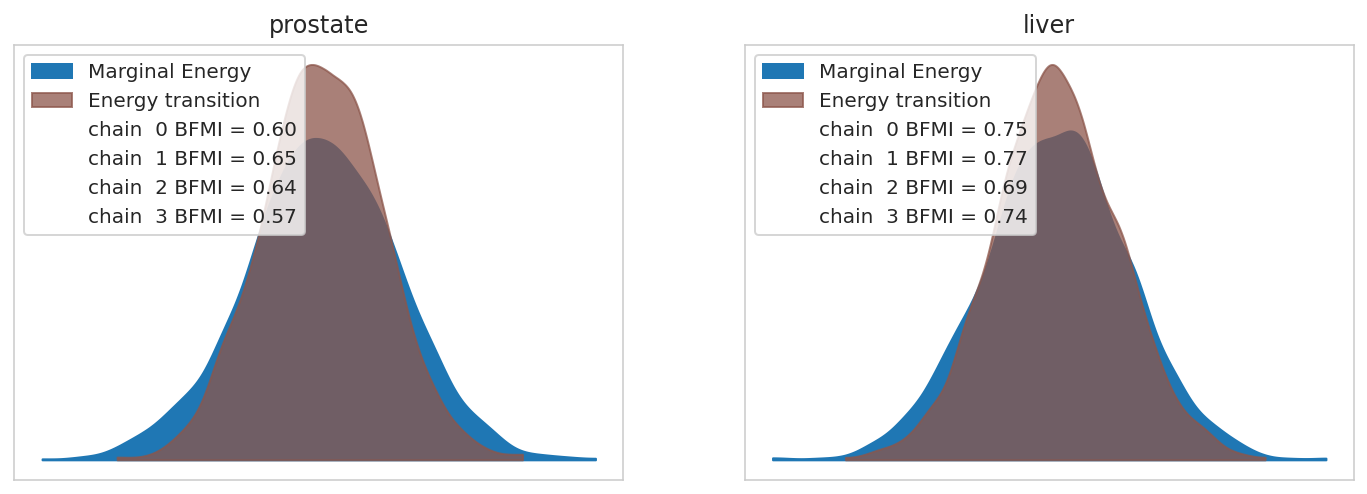

In [8]:
fig, axes = plt.subplots(1, len(posteriors), figsize=(12, 4))
for ax, pm in zip(axes, posteriors.values()):
    az.plot_energy(pm.trace, ax=ax)
    ax.set_title(pm.lineage)

plt.show()

In [9]:
def summarize_sampling_stats(trace: az.InferenceData) -> pd.DataFrame:
    stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
    return trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()


def summarize_lineage_model_sampling_stats(pm: PosteriorManager) -> pd.DataFrame:
    return summarize_sampling_stats(pm.trace).assign(lineage=pm.lineage)


pd.concat(
    [summarize_lineage_model_sampling_stats(pm) for pm in posteriors.values()]
).reset_index().set_index(["lineage", "chain"])

step_size  n_steps  tree_depth  acceptance_rate        energy
lineage  chain                                                               
prostate 0       0.018534    255.0         8.0         0.978422  2.452655e+06
         1       0.018075    255.0         8.0         0.978889  2.452672e+06
         2       0.018088    255.0         8.0         0.978884  2.452727e+06
         3       0.020123    255.0         8.0         0.972362  2.452692e+06
liver    0       0.013710    255.0         8.0         0.980166  1.037015e+07
         1       0.013920    255.0         8.0         0.978854  1.037023e+07
         2       0.014037    255.0         8.0         0.979270  1.037023e+07
         3       0.014190    255.0         8.0         0.977795  1.037012e+07

In [10]:
def _md_lineage(pm: PosteriorManager) -> None:
    display(Markdown(f"**{pm.lineage.capitalize()}**"))

**Prostate**

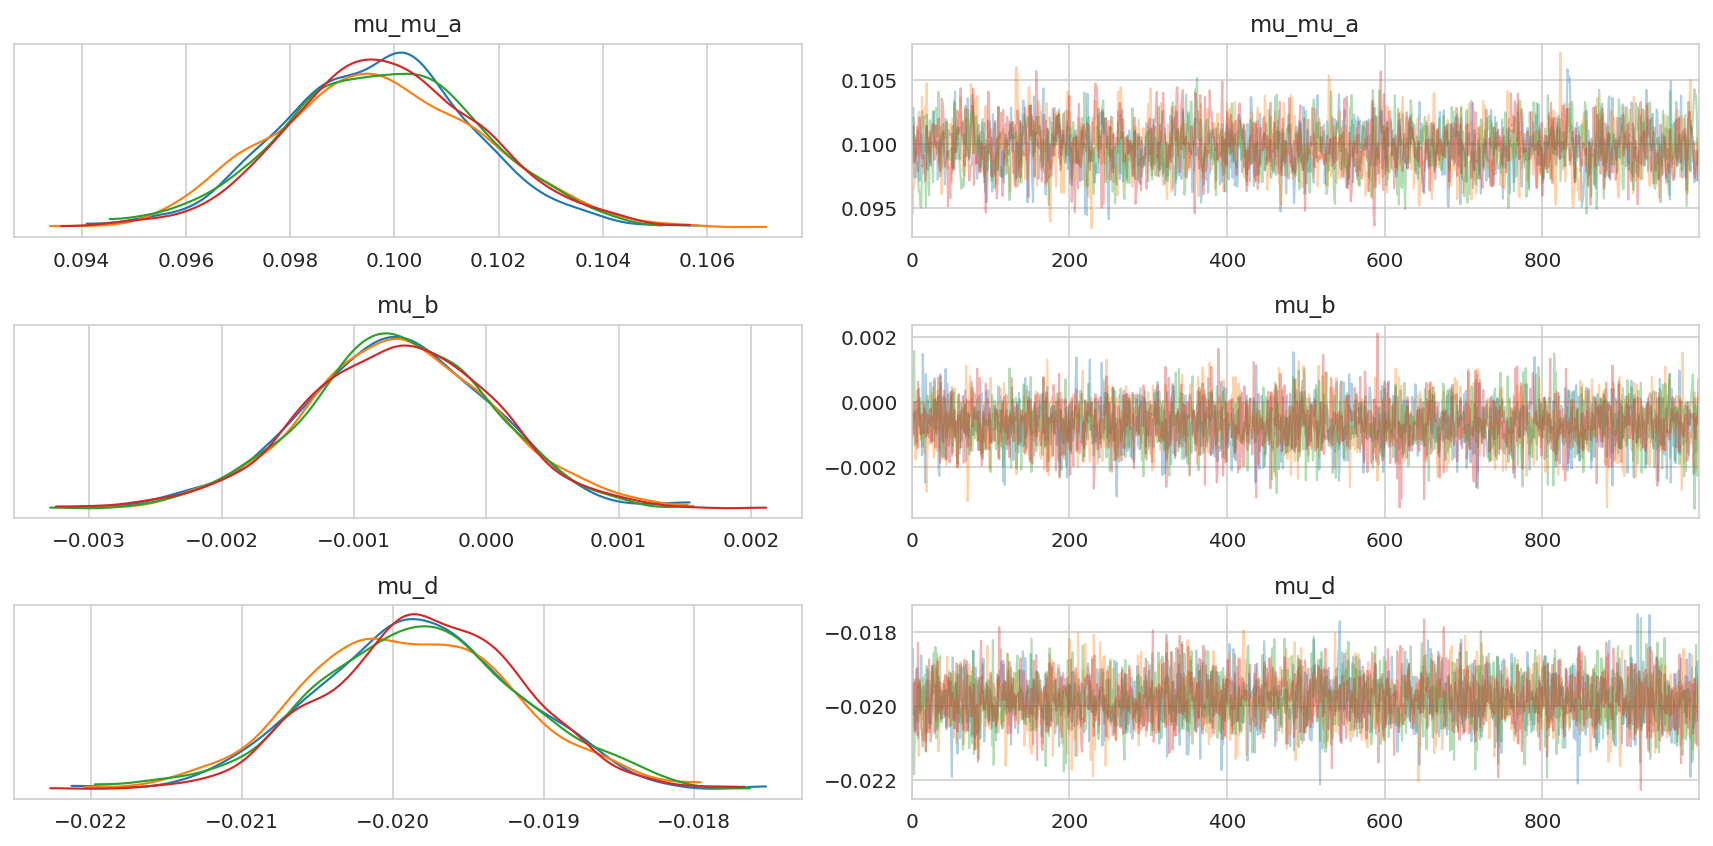

**Liver**

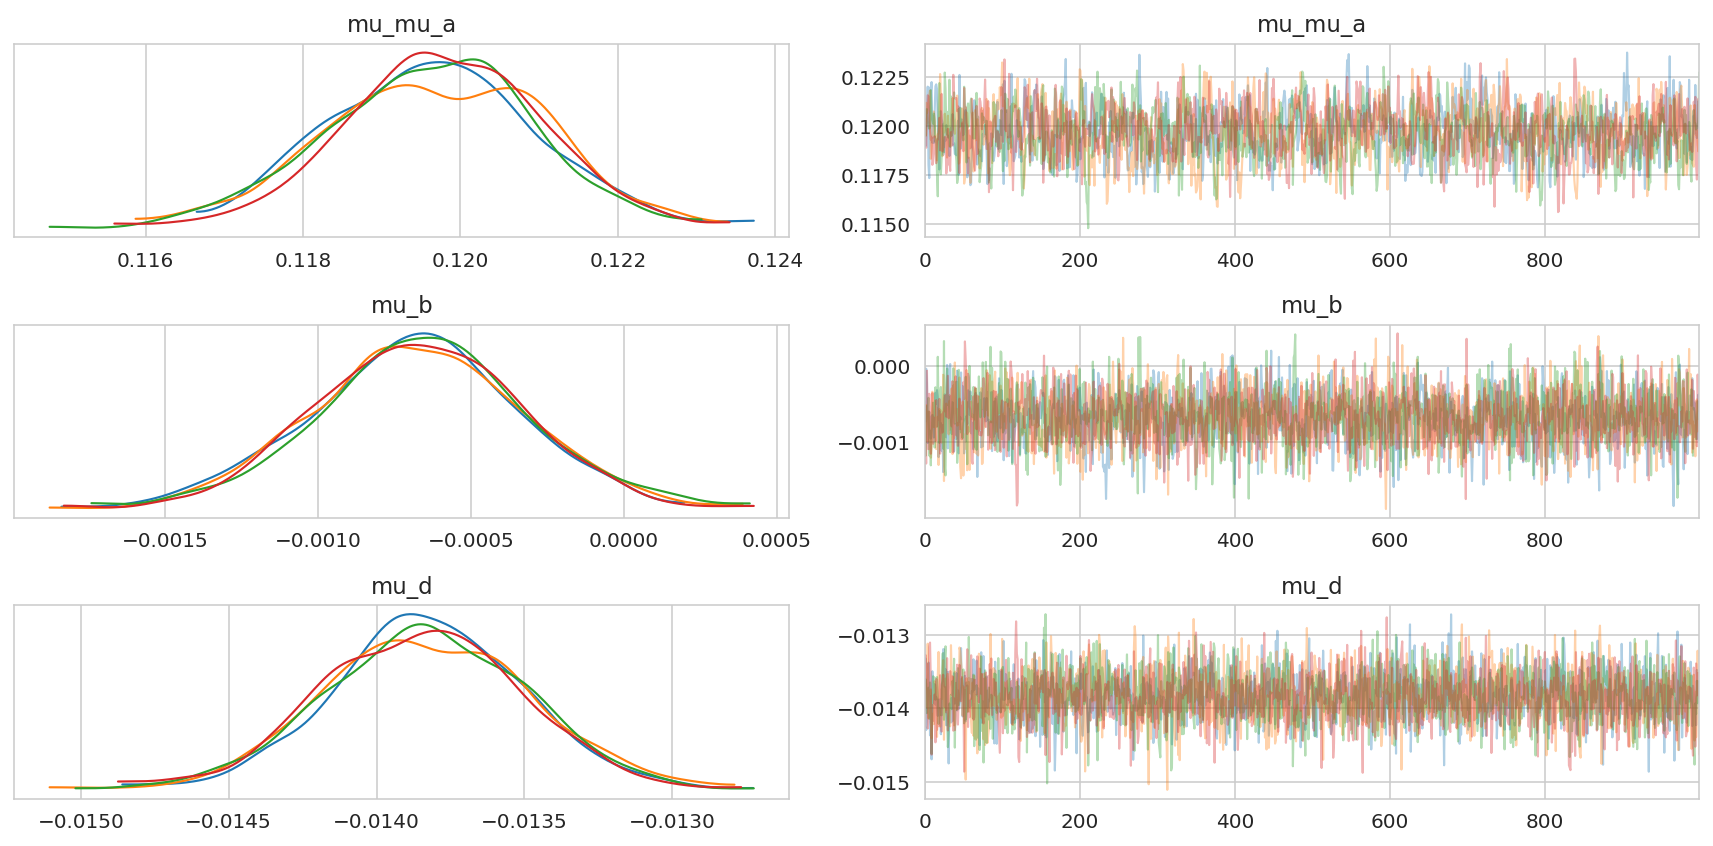

In [11]:
for pm in posteriors.values():
    _md_lineage(pm)
    az.plot_trace(pm.trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
    plt.tight_layout()
    plt.show()

**Prostate**

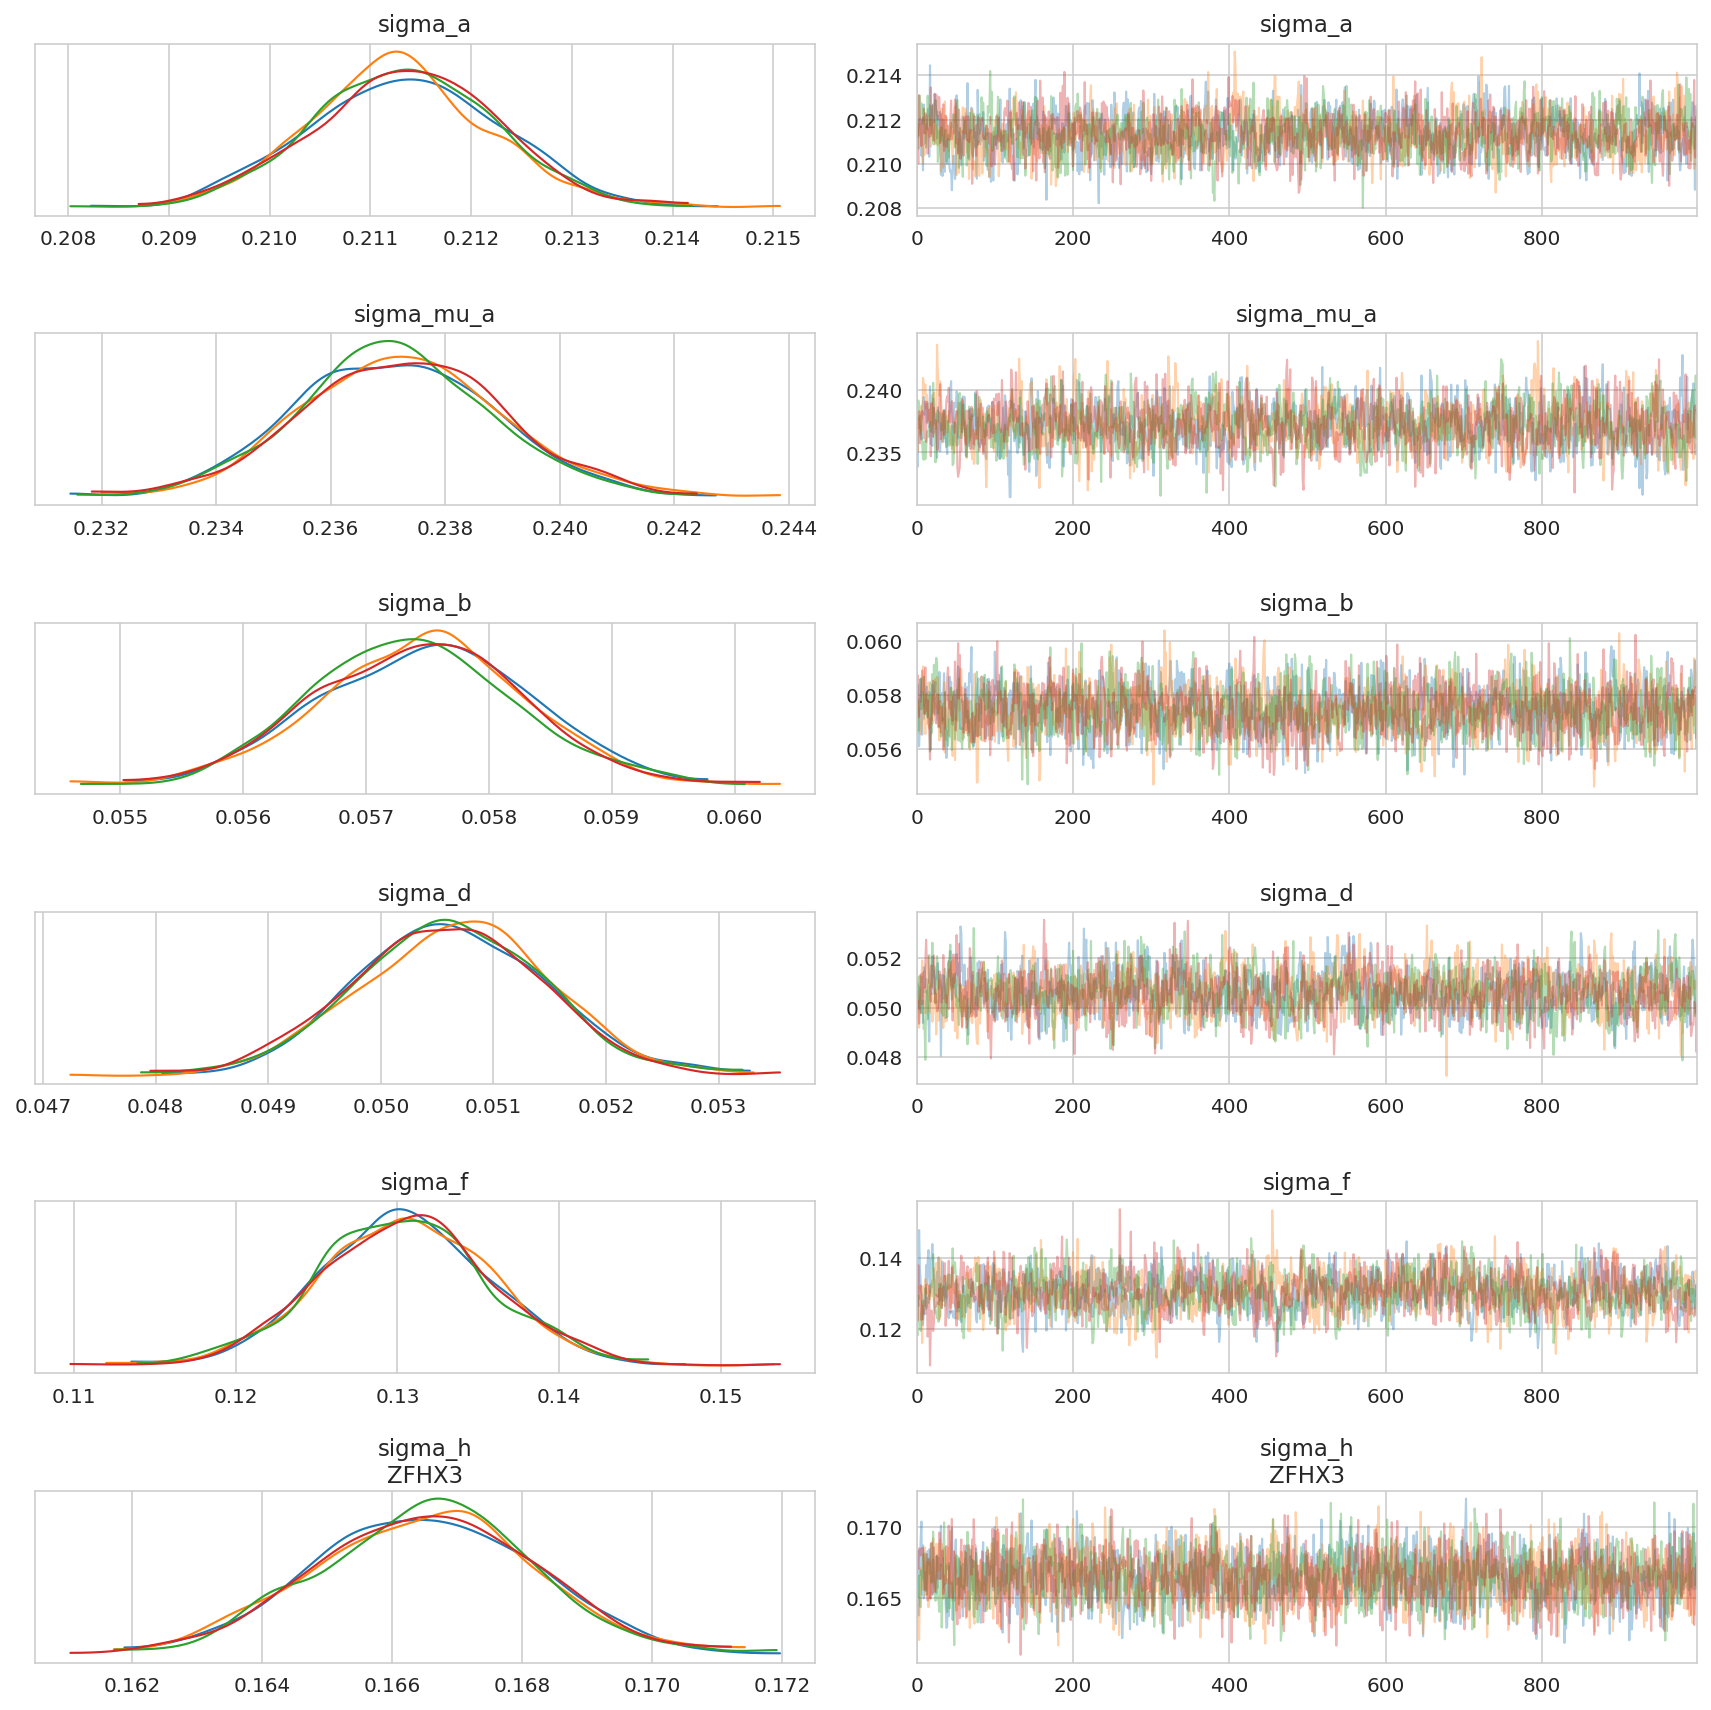

**Liver**

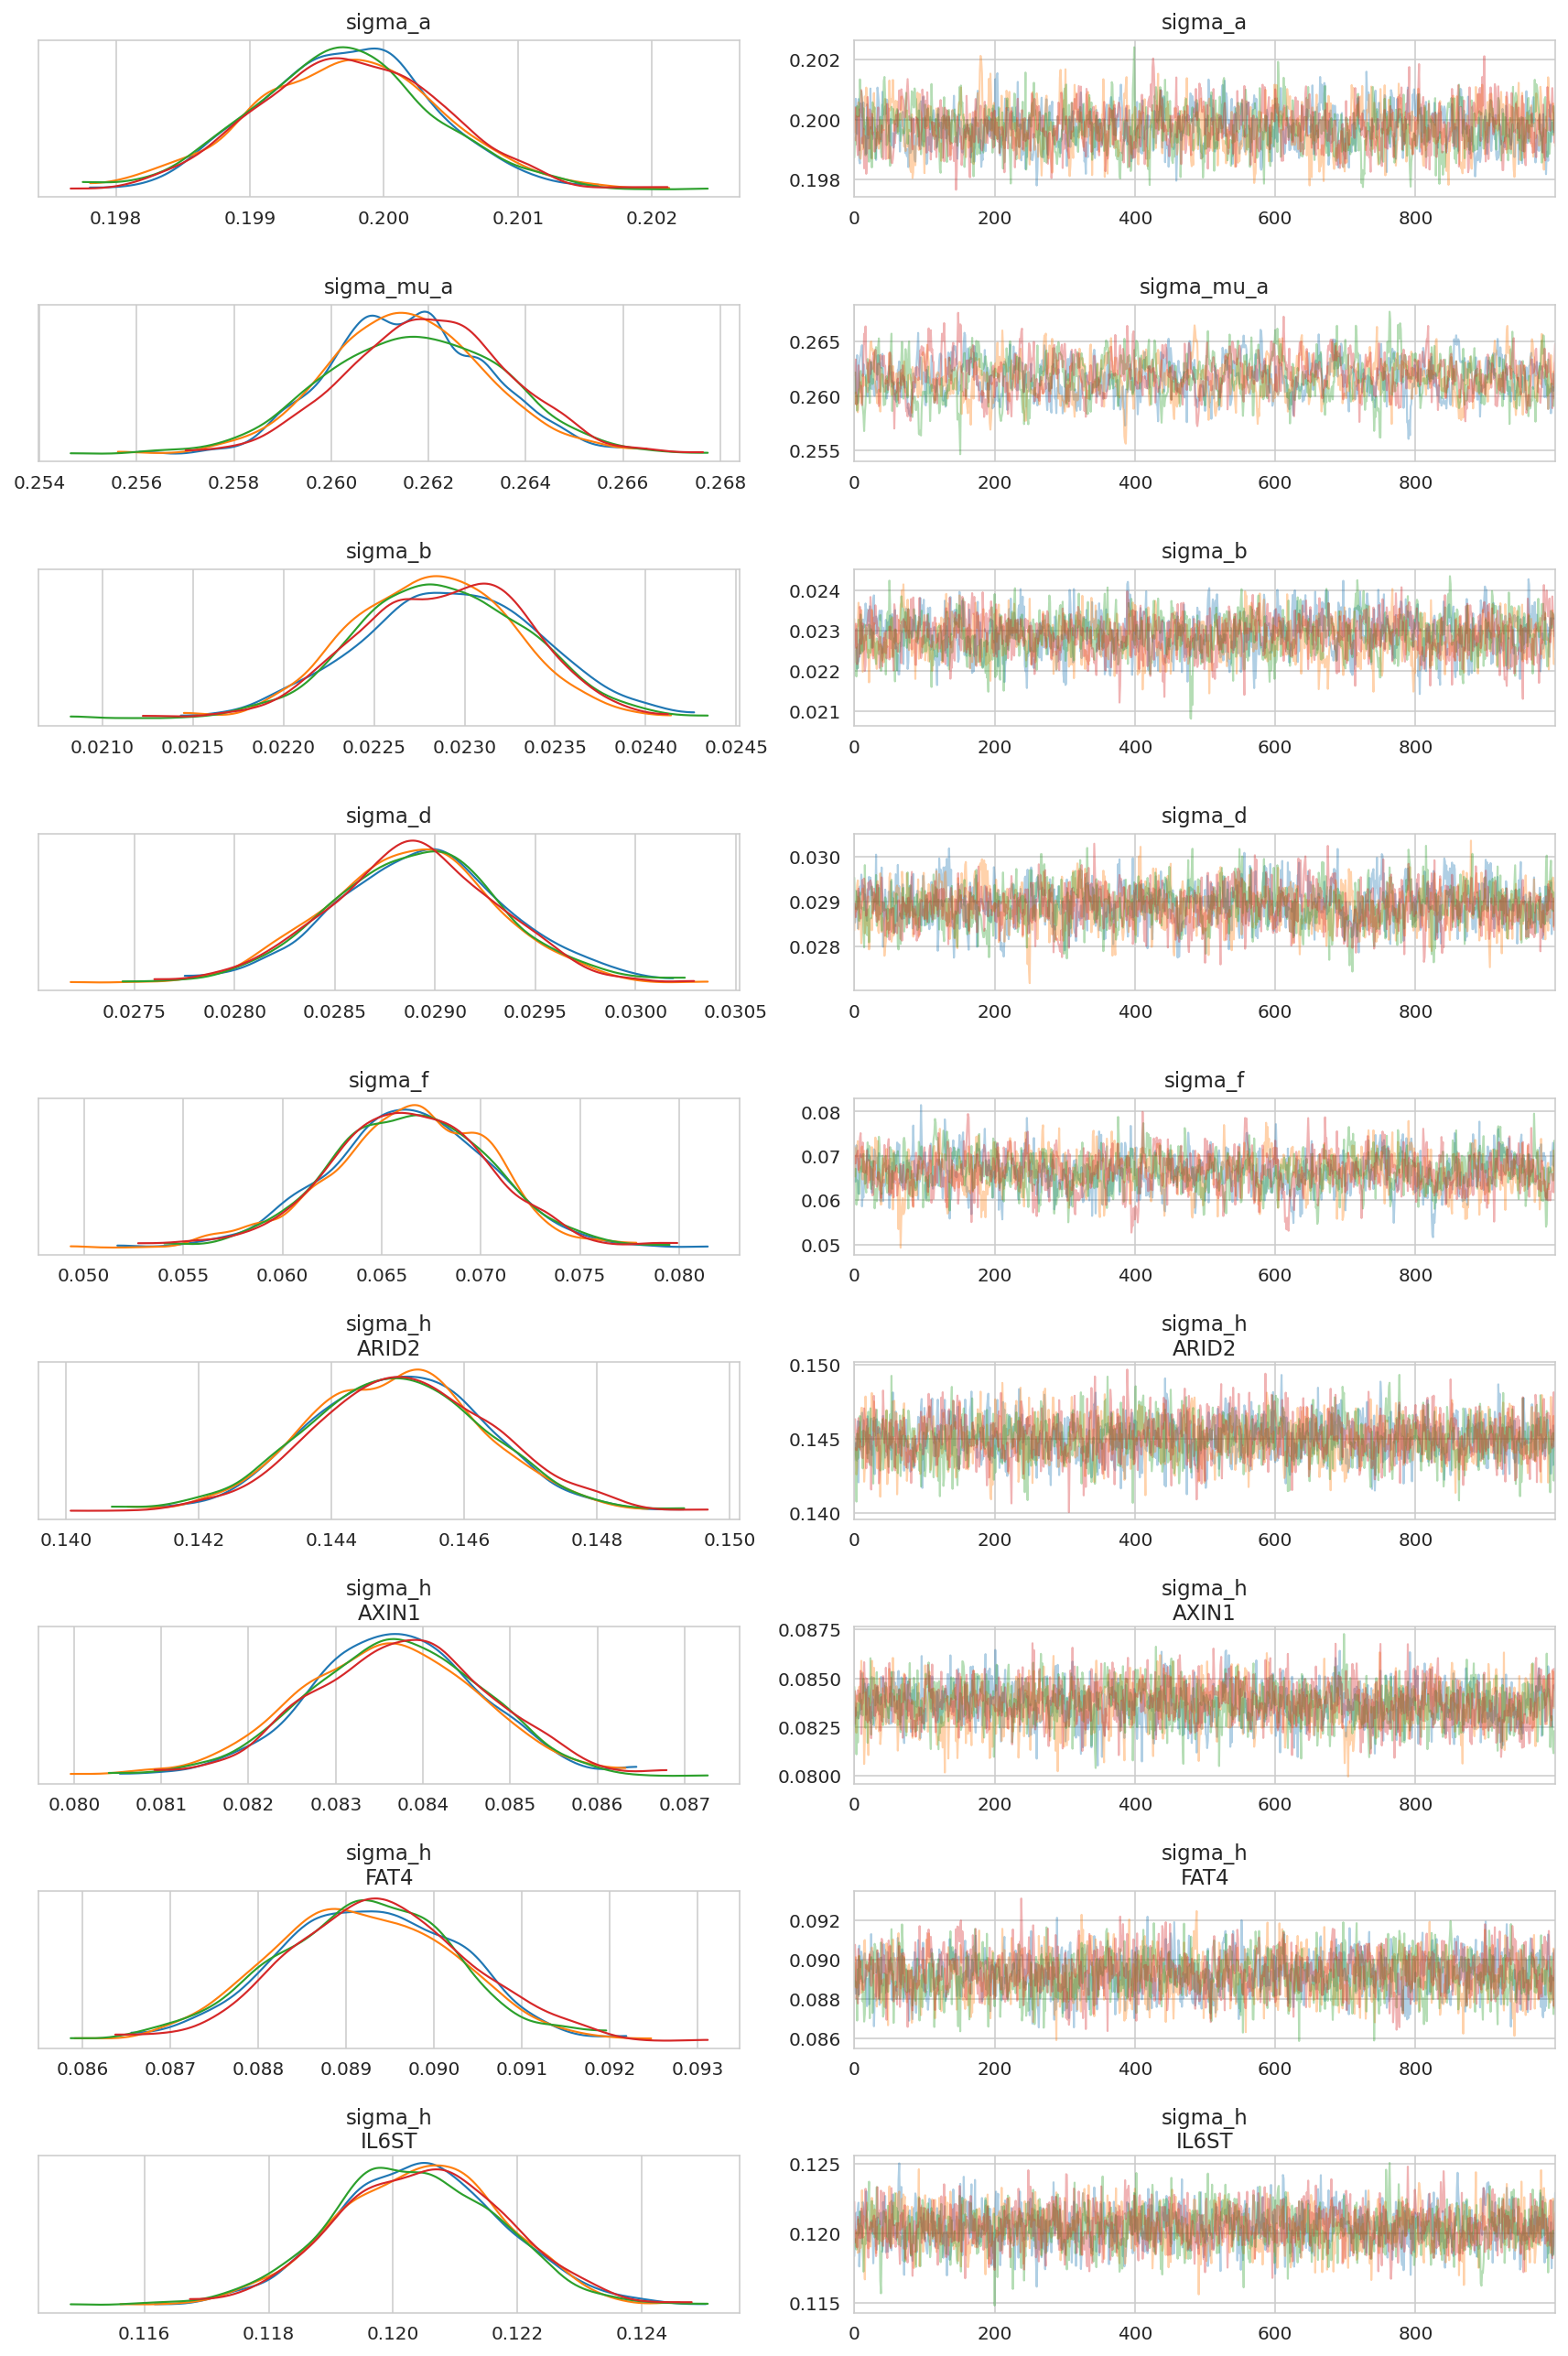

In [12]:
for pm in posteriors.values():
    _md_lineage(pm)
    az.plot_trace(pm.trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
    plt.tight_layout()
    plt.show()

**Prostate**

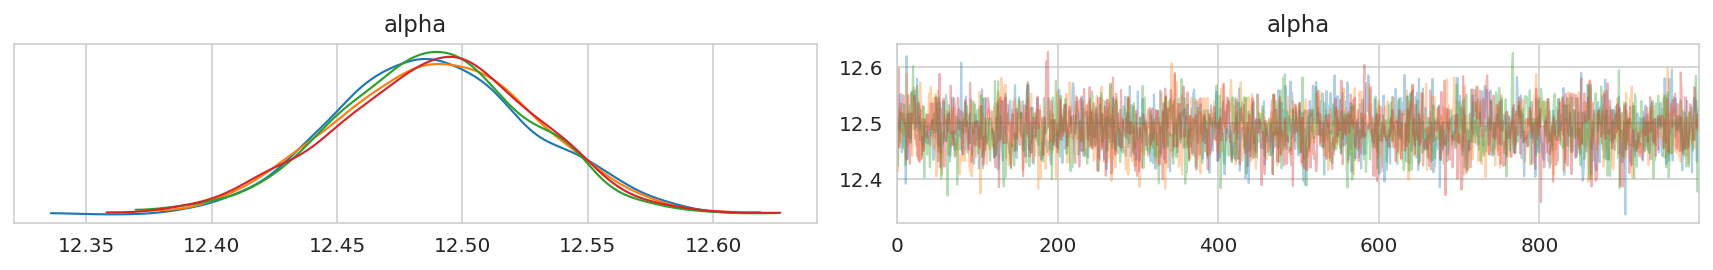

**Liver**

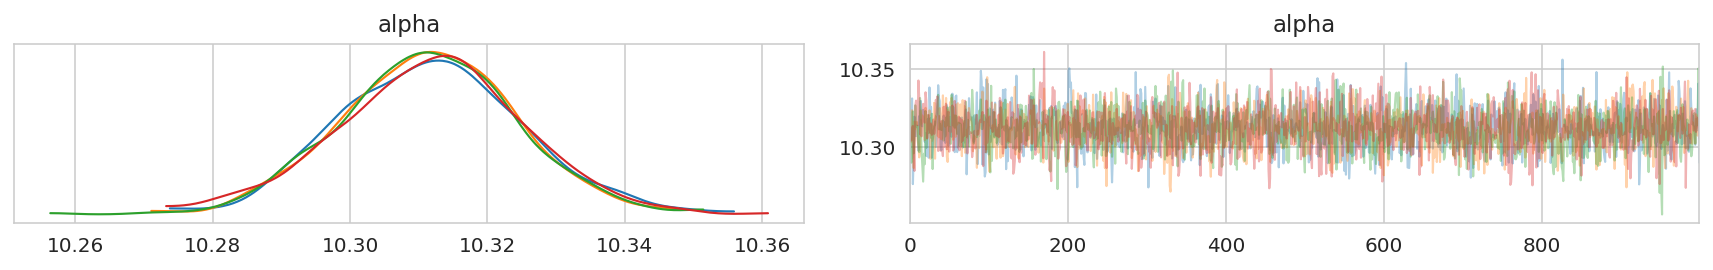

In [13]:
for pm in posteriors.values():
    _md_lineage(pm)
    az.plot_trace(pm.trace, var_names=["alpha"], compact=False)
    plt.tight_layout()
    plt.show()

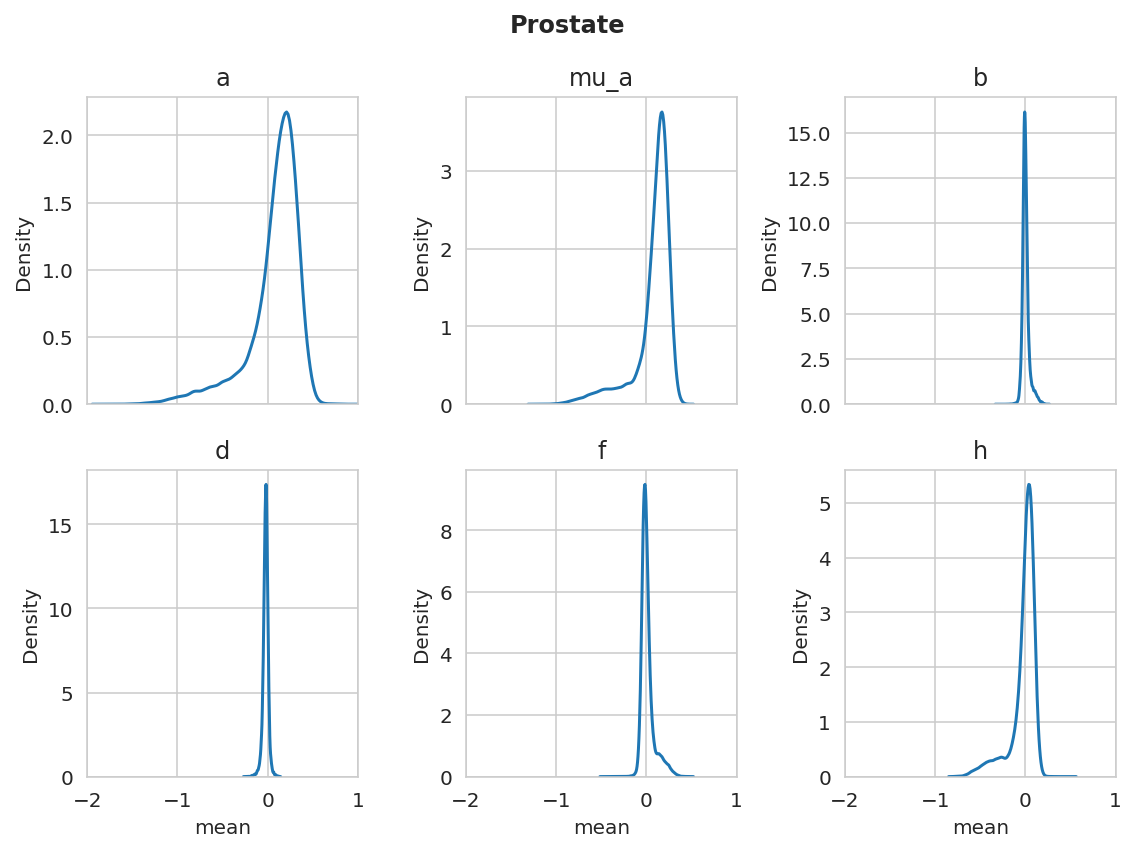

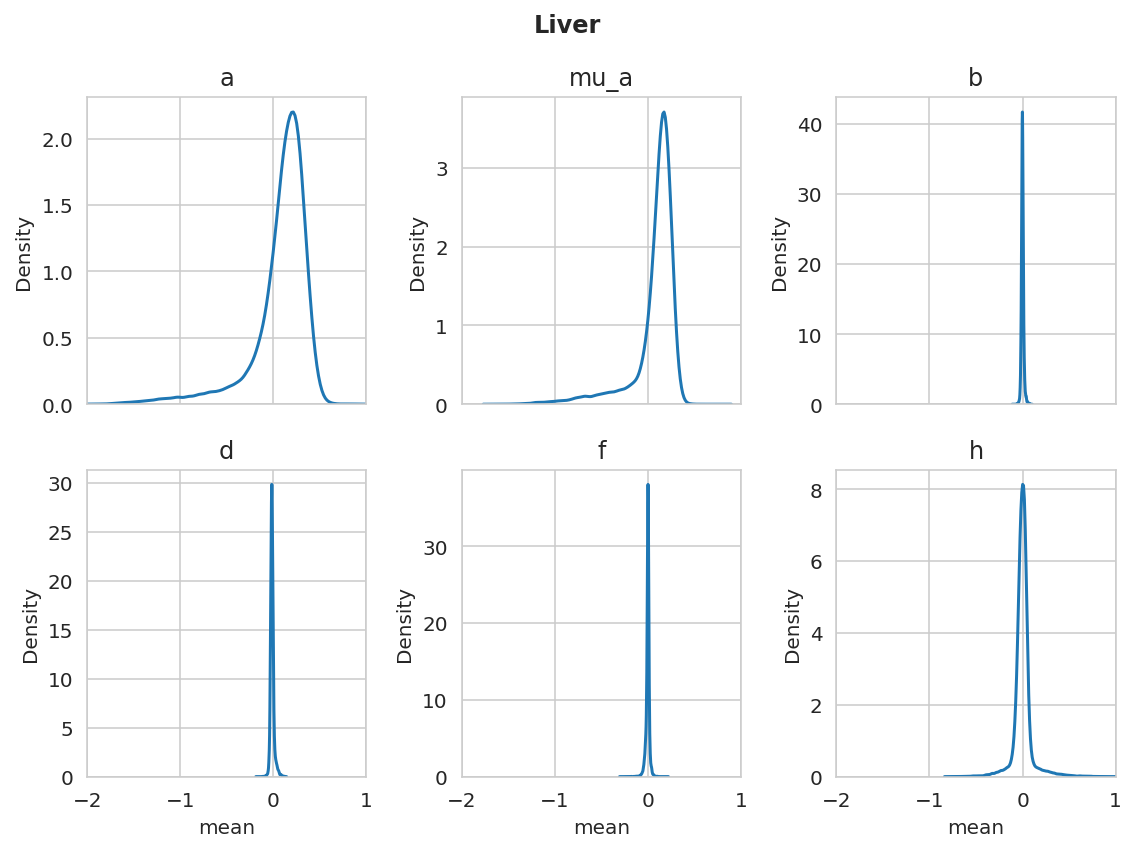

In [14]:
for pm in posteriors.values():
    var_names = ["a", "mu_a", "b", "d", "f", "h"]
    fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
    for ax, var_name in zip(axes.flatten(), var_names):
        x = pm.posterior_summary.query(f"var_name == '{var_name}'")["mean"]
        sns.kdeplot(x=x, ax=ax)
        ax.set_title(var_name)
        ax.set_xlim(-2, 1)

    fig.suptitle(pm.lineage.capitalize(), fontweight="bold")
    plt.tight_layout()
    plt.show()

In [15]:
def sgrna_to_gene_map(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)

**Prostate**

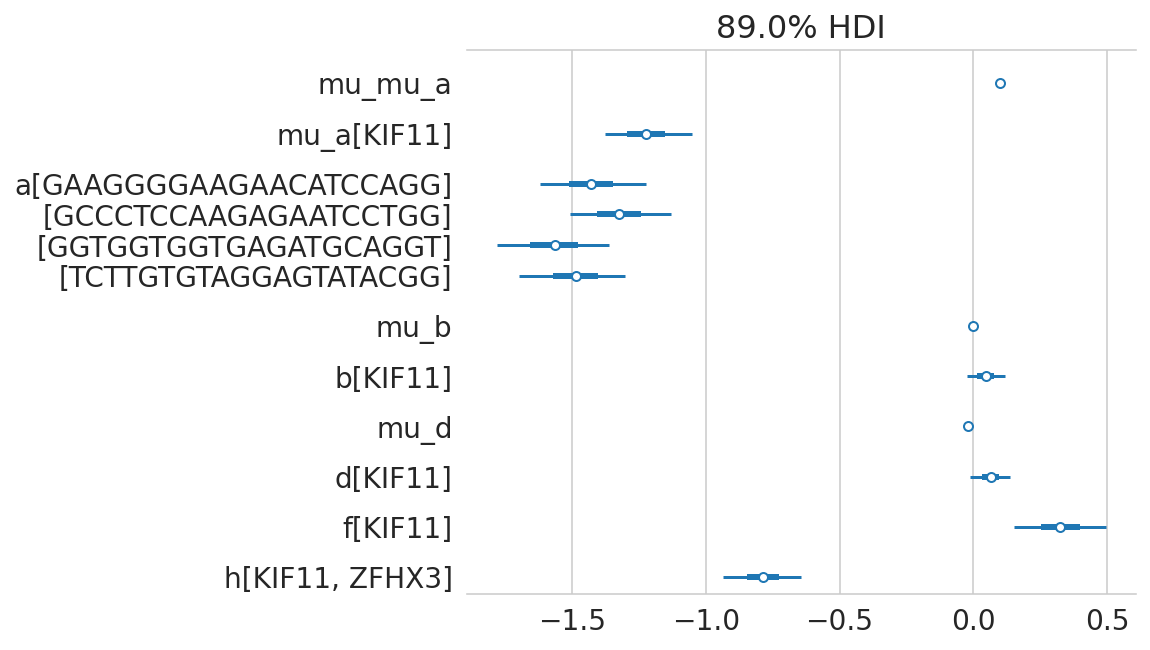

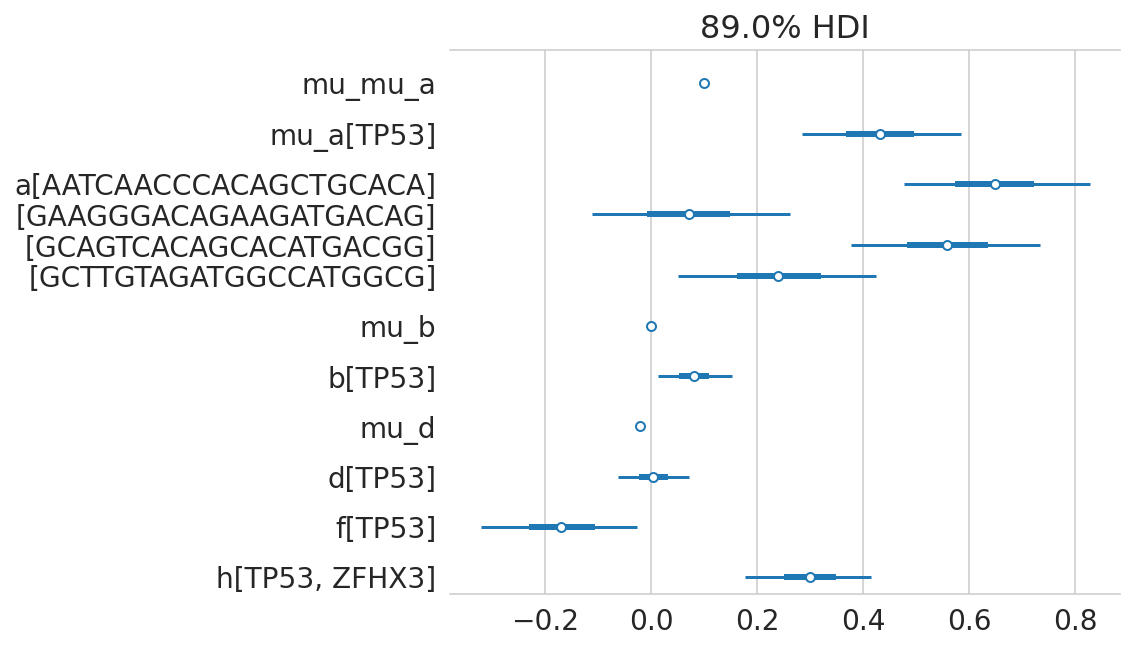

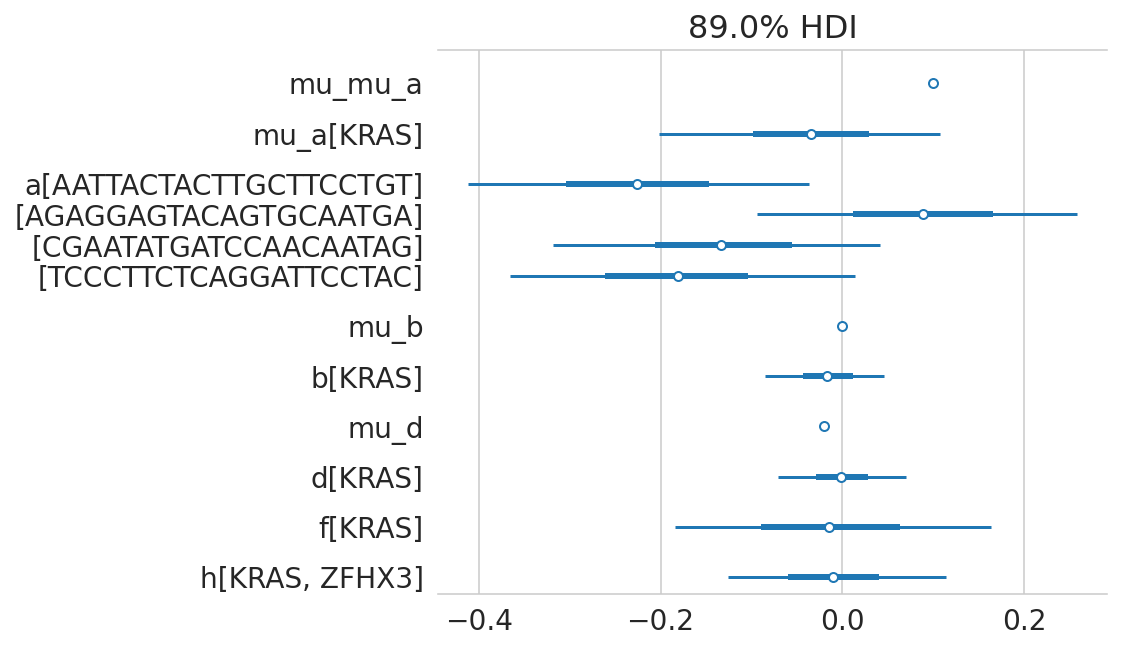

**Liver**

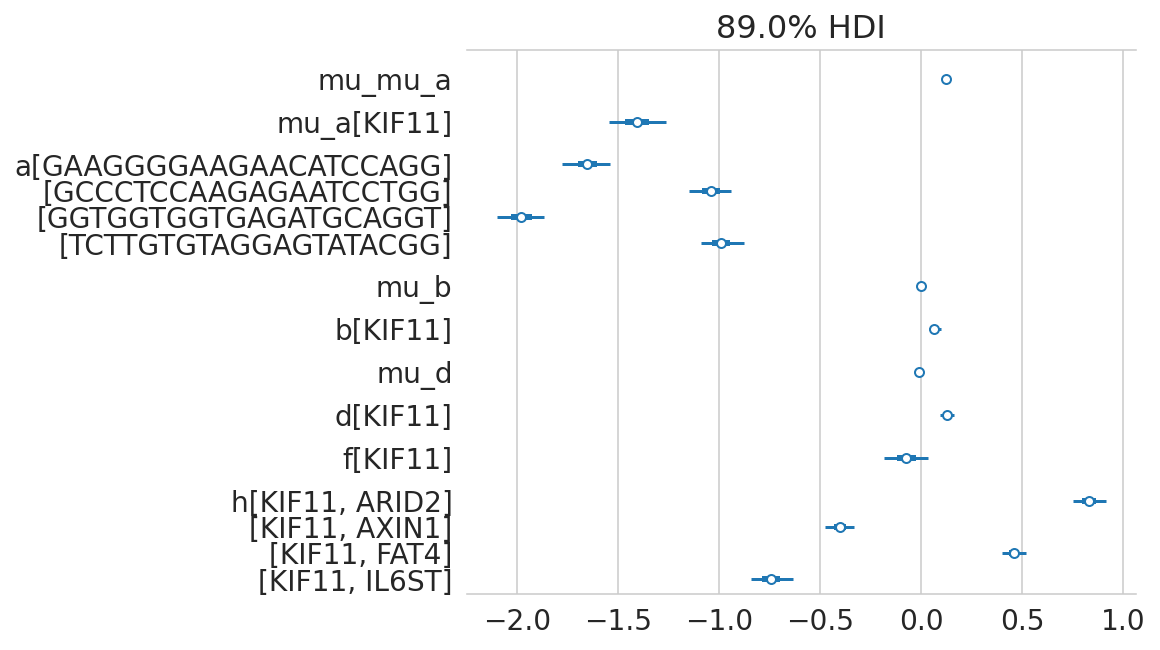

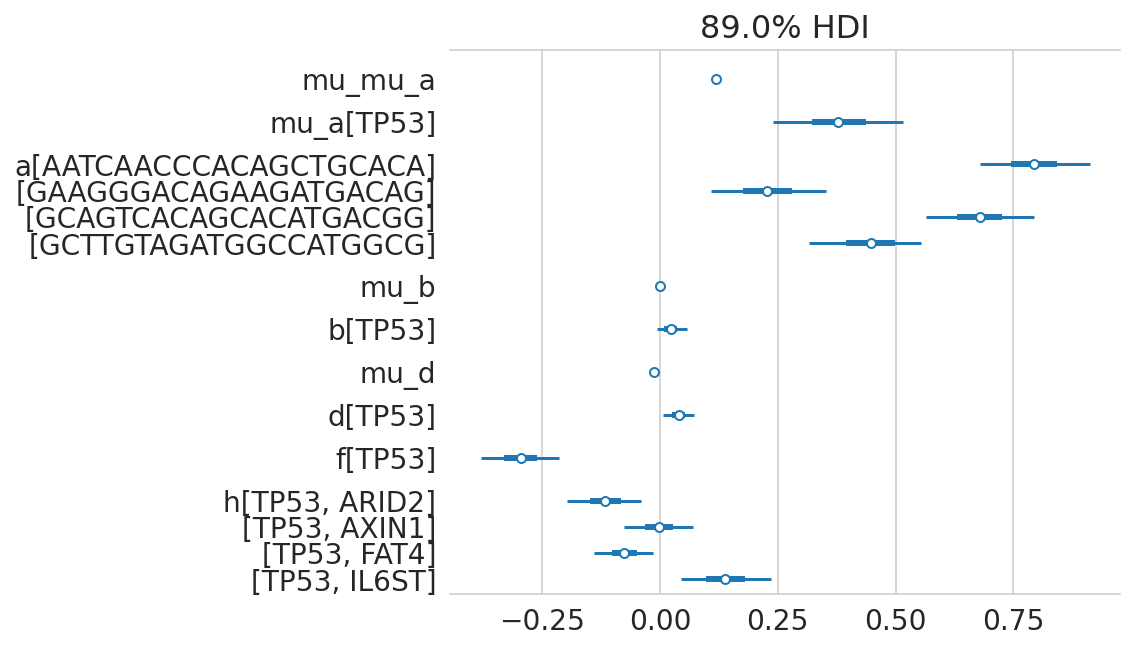

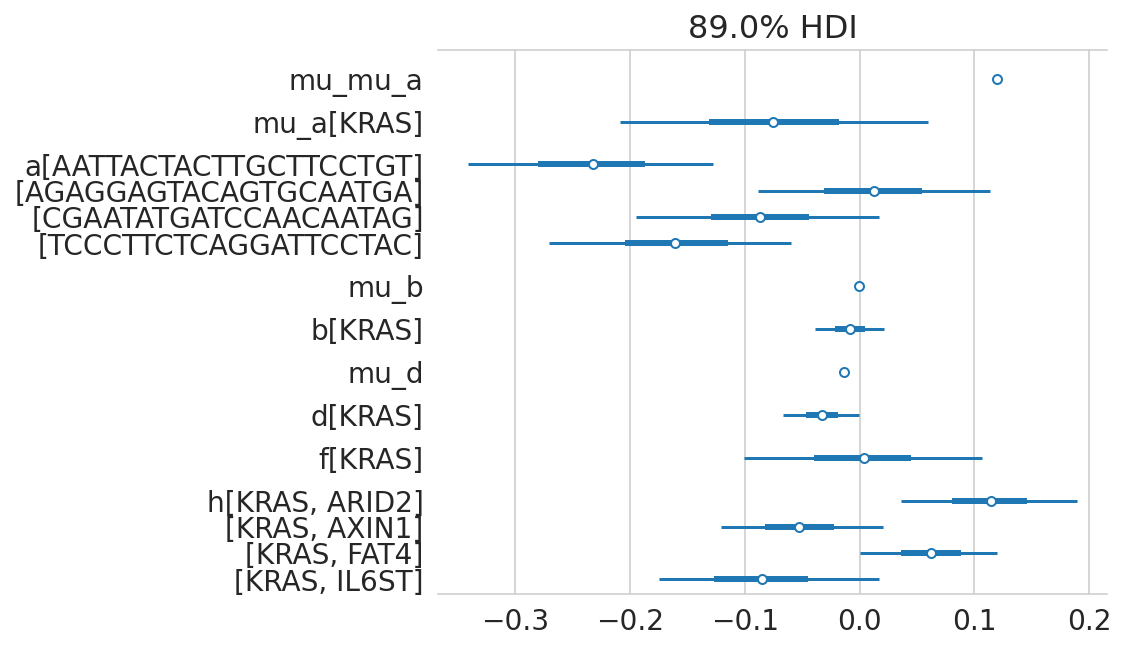

In [16]:
example_genes = ["KIF11", "TP53", "KRAS"]

for pm in posteriors.values():
    _md_lineage(pm)
    lineage_sgrna_map = sgrna_to_gene_map(pm.data)
    for gene in example_genes:
        example_gene_sgrna = (
            lineage_sgrna_map.copy().query(f"hugo_symbol == '{gene}'")["sgrna"].tolist()
        )
        az.plot_forest(
            pm.trace,
            var_names=["mu_mu_a", "mu_a", "a", "mu_b", "b", "mu_d", "d", "f", "h"],
            coords={"gene": [gene], "sgrna": example_gene_sgrna},
            combined=True,
            figsize=(6, 5),
        )
        plt.show()

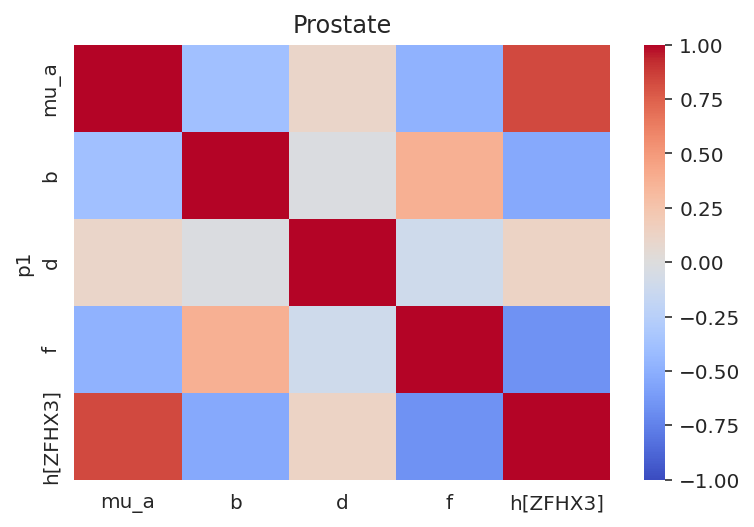

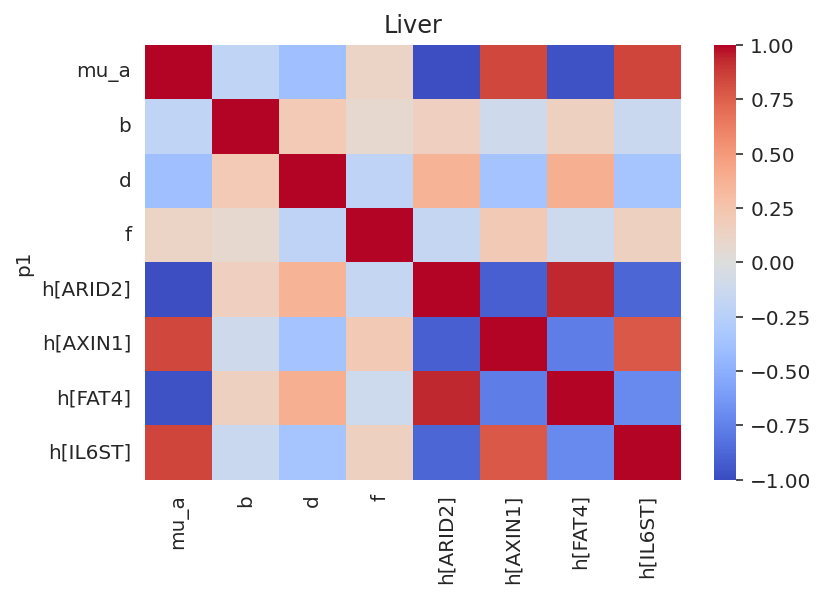

In [17]:
for pm in posteriors.values():
    genes_var_names = ["mu_a", "b", "d", "f"]
    genes_var_names += [
        f"h[{g}]" for g in pm.trace.posterior.coords["cancer_gene"].values
    ]
    gene_corr_post = (
        az.summary(pm.trace, "genes_chol_cov_corr", kind="stats")
        .pipe(extract_coords_param_names, names=["d1", "d2"])
        .astype({"d1": int, "d2": int})
        .assign(
            p1=lambda d: [genes_var_names[i] for i in d["d1"]],
            p2=lambda d: [genes_var_names[i] for i in d["d2"]],
        )
        .assign(
            p1=lambda d: pd.Categorical(
                d["p1"], categories=d["p1"].unique(), ordered=True
            )
        )
        .assign(
            p2=lambda d: pd.Categorical(
                d["p2"], categories=d["p1"].cat.categories, ordered=True
            )
        )
    )
    plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
    ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(pm.lineage.capitalize())
    plt.show()

In [18]:
for pm in posteriors.values():
    _md_lineage(pm)
    cancer_genes = pm.trace.posterior.coords["cancer_gene"].values.tolist()
    cancer_gene_mutants = (
        pm.valid_data.filter_column_isin("hugo_symbol", cancer_genes)[
            ["hugo_symbol", "depmap_id", "is_mutated"]
        ]
        .drop_duplicates()
        .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
        .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
        .set_index("depmap_id")
    )
    display(cancer_gene_mutants)

**Prostate**

[07/30/22 10:10:58] INFO     Processing data for modeling.     ]8;id=481999;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=529951;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=238286;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=481571;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

[07/30/22 10:12:22] WARNING  number of data points dropped: 2  ]8;id=826188;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=571754;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

**Liver**

                    INFO     Processing data for modeling.     ]8;id=310476;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=593889;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=135695;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=989523;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

[07/30/22 10:14:07] WARNING  number of data points dropped: 58 ]8;id=980917;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=480341;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

AXIN1 FAT4 ARID2 IL6ST
depmap_id                        
ACH-000217     X                 
ACH-000221                       
ACH-000316                       
ACH-000361                       
ACH-000393                       
ACH-000420     X          X      
ACH-000422                      X
ACH-000471                       
ACH-000475     X                 
ACH-000476                       
ACH-000478          X            
ACH-000480                       
ACH-000483          X            
ACH-000493     X                 
ACH-000537                       
ACH-000577          X            
ACH-000620                      X
ACH-000671                       
ACH-000734     X                 
ACH-000739                       
ACH-000848     X          X      
ACH-001318

**Prostate**

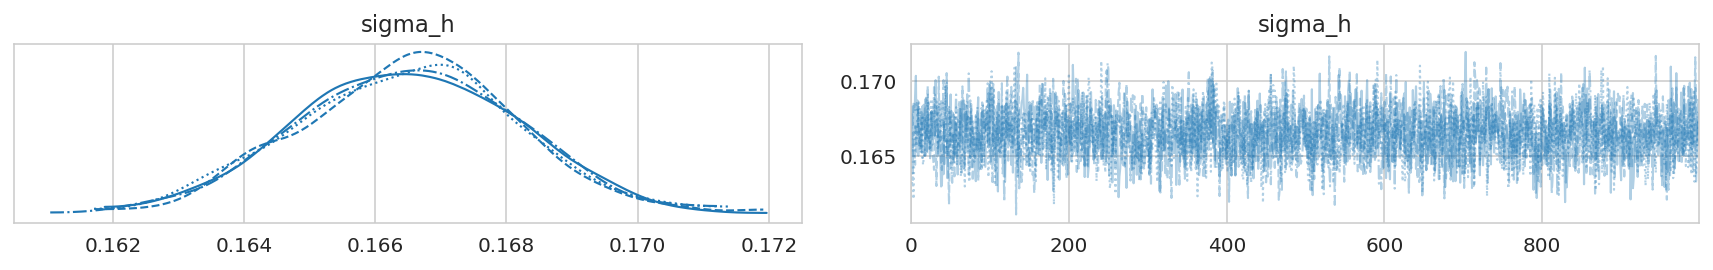

**Liver**

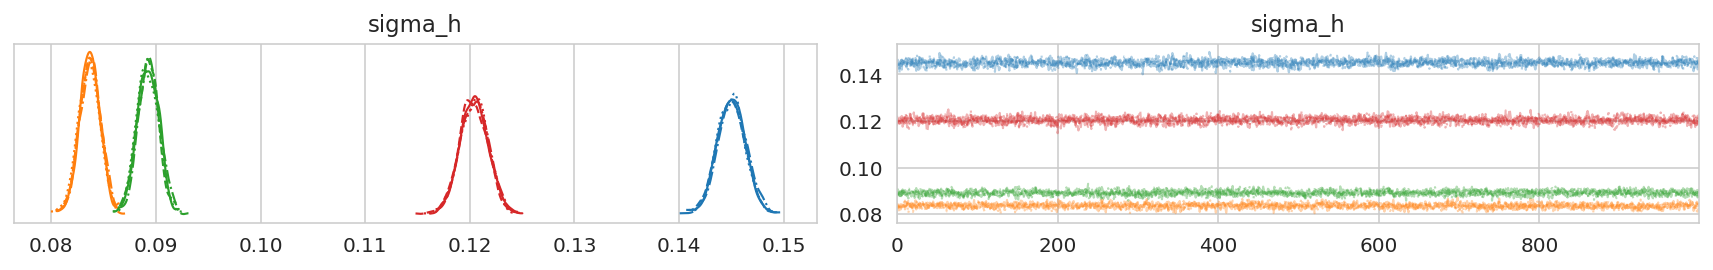

In [19]:
for pm in posteriors.values():
    _md_lineage(pm)
    az.plot_trace(pm.trace, var_names=["sigma_h"], compact=True)
    plt.tight_layout()
    plt.show()

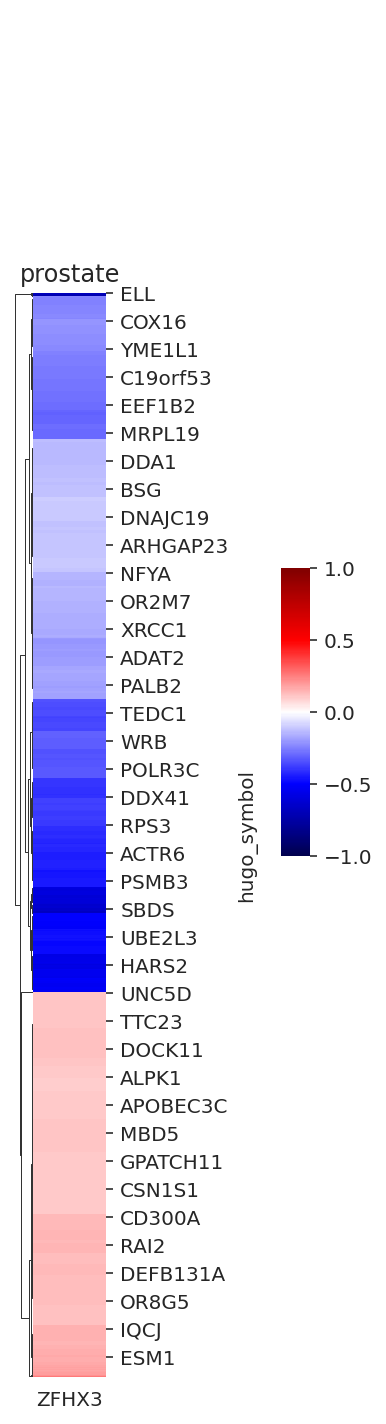

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


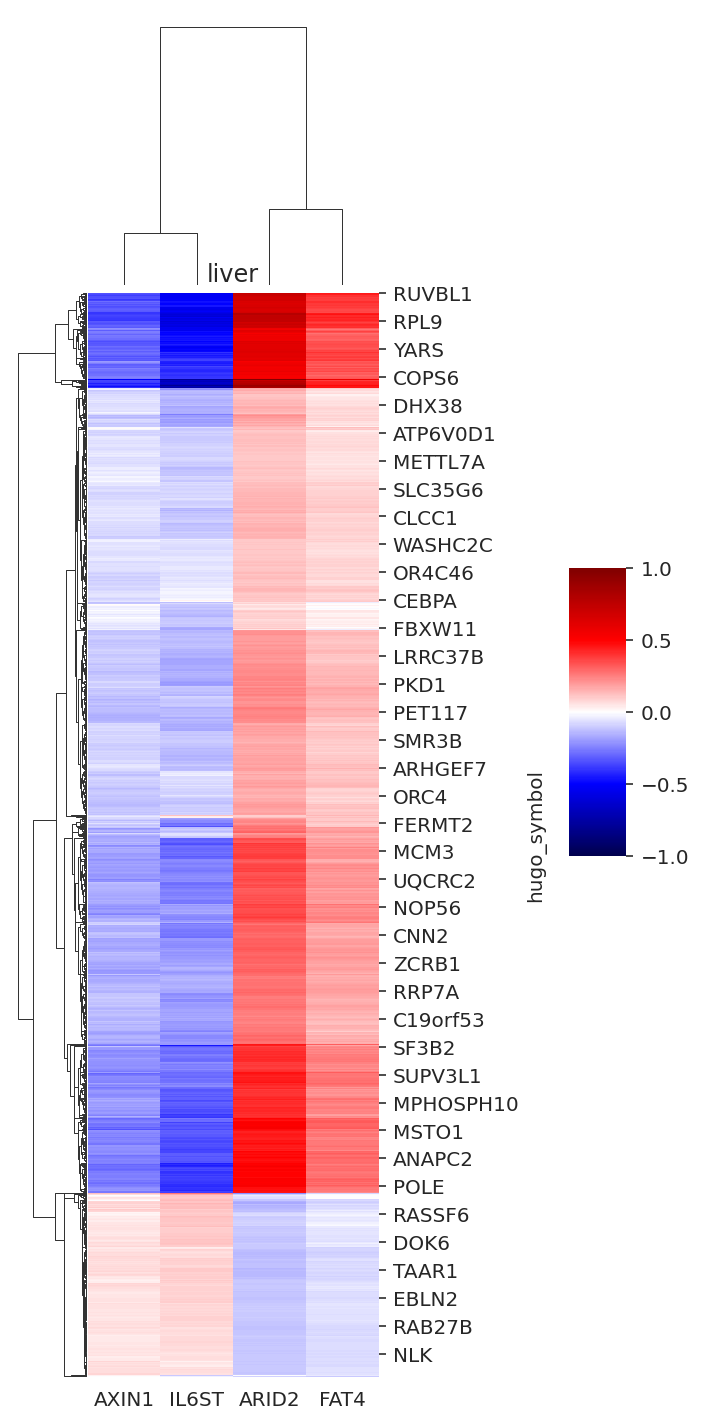

In [20]:
for pm in posteriors.values():
    h_post_summary = (
        pm.posterior_summary.query("var_name == 'h'")
        .reset_index(drop=True)
        .pipe(
            extract_coords_param_names,
            names=["hugo_symbol", "cancer_gene"],
            col="parameter",
        )
    )
    genes_to_plot = h_post_summary.query("mean.abs() > 0.1")["hugo_symbol"].toset()
    plot_df = (
        h_post_summary.filter_column_isin("hugo_symbol", genes_to_plot)
        .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean")
        .set_index("hugo_symbol")
    )
    width = min(max(plot_df.shape[1], 2), 5)
    cg = sns.clustermap(
        plot_df,
        col_cluster=h_post_summary["cancer_gene"].nunique() > 1,
        figsize=(width, 10),
        cbar_pos=(1, 0.4, 0.1, 0.2),
        cmap="seismic",
        vmin=-1,
        vmax=1,
    )
    cg.ax_heatmap.set_title(pm.lineage)
    plt.show()

## PPC

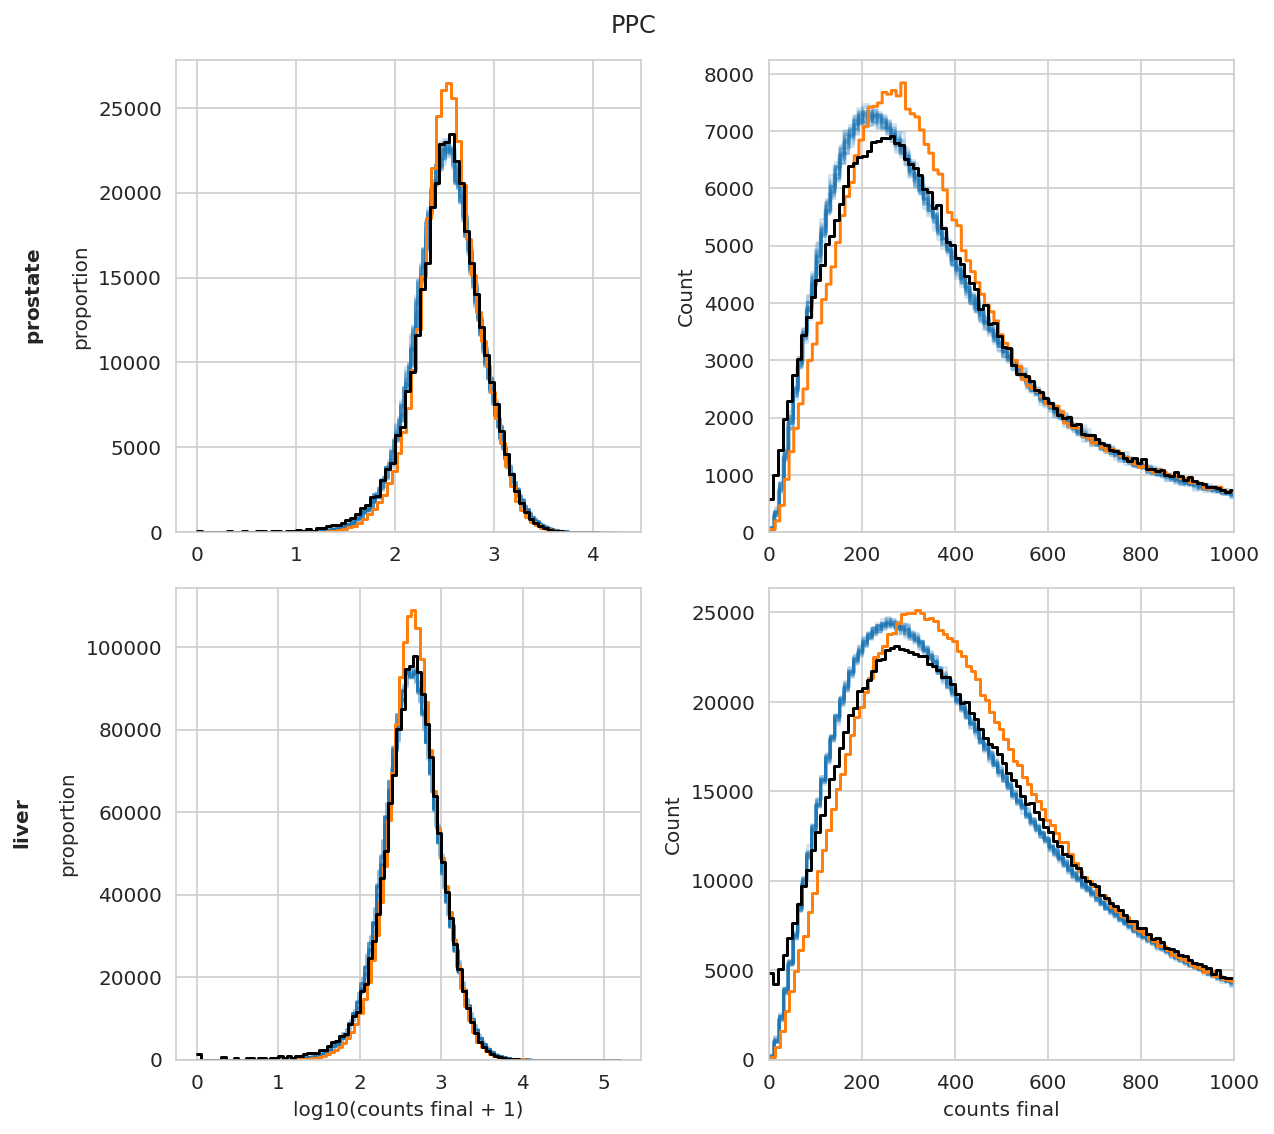

In [24]:
fig, axes = plt.subplots(
    nrows=len(posteriors), ncols=2, figsize=(9, len(posteriors) * 4)
)

hist_plot_kwargs = {"fill": False, "element": "step", "stat": "count"}

for i, pm in enumerate(posteriors.values()):
    axes[i, 0].set_ylabel(f"$\mathbf{{{pm.lineage}}}$\n\nproportion")

    # Collect random draws from posterior predictive.
    n_examples = 20
    n_chains, n_draws, n_data = pm.trace.posterior_predictive["ct_final"].shape
    ex_draws_idx = np.random.choice(
        np.arange(n_draws), size=n_examples // n_chains, replace=False
    )
    example_ppc_draws = pm.trace.posterior_predictive["ct_final"][
        :, ex_draws_idx, :
    ].values.reshape(-1, n_data)

    # Plot
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    pp_avg = pm.trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

    bw = 0.05
    for i in range(example_ppc_draws.shape[0]):
        sns.histplot(
            x=np.log10(example_ppc_draws[i, :] + 1),
            color="tab:blue",
            alpha=0.2,
            binwidth=bw,
            ax=ax1,
            **hist_plot_kwargs,
        )

    sns.histplot(
        x=np.log10(pp_avg + 1),
        color="tab:orange",
        alpha=1,
        binwidth=bw,
        ax=ax1,
        **hist_plot_kwargs,
    )
    sns.histplot(
        x=np.log10(pm.valid_data["counts_final"] + 1),
        color="k",
        alpha=1,
        binwidth=bw,
        ax=ax1,
        **hist_plot_kwargs,
    )

    bw = 10
    for i in range(example_ppc_draws.shape[0]):
        sns.histplot(
            x=example_ppc_draws[i, :],
            color="tab:blue",
            alpha=0.2,
            binwidth=bw,
            ax=ax2,
            **hist_plot_kwargs,
        )

    sns.histplot(
        x=pp_avg, color="tab:orange", alpha=1, binwidth=bw, ax=ax2, **hist_plot_kwargs
    )
    sns.histplot(
        x=pm.valid_data["counts_final"],
        color="k",
        alpha=1,
        binwidth=bw,
        ax=ax2,
        **hist_plot_kwargs,
    )

    ax1.set_xlabel(None)
    ax2.set_xlabel(None)
    ax2.set_xlim(0, 1000)

axes[-1, 0].set_xlabel("log10(counts final + 1)")
axes[-1, 1].set_xlabel("counts final")

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [22]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 15.87 minutes


In [23]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-30

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-160.o2.rc.hms.harvard.edu

Git branch: simplify

qnorm     : 0.8.1
seaborn   : 0.11.2
numpy     : 1.22.4
matplotlib: 3.5.2
arviz     : 0.12.1
pandas    : 1.4.3

